# CPSC 330 Lecture 2

# Lecture outline

- Wave hello
- **!! Turn on recording !!**
- Announcements (5 min)
- Cilantro dataset (5 min)
- Decision trees (30 min)
- Break (5 min)
- True/False questions (15 min)
- ML model parameters and hyperparameters (5 min)
- Overfitting (15 min)

## Learning objectives

- Explain how a decision tree classifier makes predictions
- Interpret a diagram of a decision tree 
- Interpret a decision boundary plot for datasets with 2 numeric features (like the cilantro dataset)
- Appropriately use `fit`, `predict`, and `score` in scikit-learn
- Explain the `max_depth` hyperparameter of `DecisionTreeClasifier`
- Explain the scenario in which a `DecisionTreeClassifier` with `max_depth=None` would not get 100% training accuracy
- Distinguish between parameters and hyperparameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from plot_classifier import plot_classifier

In [2]:
import re
import graphviz
from sklearn.tree import export_graphviz

def display_tree(feature_names, tree):
    """ For binary classification only """
    dot = export_graphviz(tree, out_file=None, feature_names=feature_names, class_names=tree.classes_.astype(str), impurity=False)
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    dot = re.sub(     '(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
    return graphviz.Source(dot)

## Announcements (5 min)

- hw1 due tonight at 11:59pm
- hw2 will be released tomorrow, due Monday 11:59pm
  - See [here](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md#groups) for instructions on working with a partner.
  - You are free to work alone or with a partner.
- On the usual schedule, hw will be due Mondays and released Tuesdays
- My evening office hour moved from Wed to Thu 
  - Note I have 30 min morning OH and 30 min evening OH.
- Update on the plan for the final exam:
  - We will **not** have a regular 2.5 hour exam in the regular way.
  - There will be a take-home, with a mix of coding and conceptual questions.
  - The time window will be 24-48 hours (exact time window TBD).
  - Open book.
- Update on the plan for the midterm:
  - We'll do it on Canvas during class time on Oct 22.
  - This will be the one time you'll need to operate in the middle of the night if you're in a far time zone (sorry).
  - Probably open book.
- Please monitor Piazza (especially pinned posts and instructor posts) for announcements.
- Sorry for the setup difficulties.

## Cilantro dataset (5 min)

Here's the dataset you generated last class!

In [3]:
df = pd.read_csv('data/330-students-cilantro.csv')
df.head()

,What percentage of days do you typically eat meat or fish?,What percentage grade do you expect to get in this course?,Do you like cilantro?
0,42.0,90,Yes
1,85.0,83,No
2,28.0,83,Yes
3,100.0,80,No
4,100.0,75,No


In [4]:
df.columns = ["meat", "grade", "cilantro"]
df.head()

,meat,grade,cilantro
0,42.0,90,Yes
1,85.0,83,No
2,28.0,83,Yes
3,100.0,80,No
4,100.0,75,No


In [5]:
df.describe()

,meat,grade
count,200.000000,200.000000
mean,72.812850,83.440000
std,31.605226,8.633603
min,0.000000,4.000000
25%,50.000000,80.000000
50%,86.000000,85.000000
75%,100.000000,90.000000
max,100.000000,100.000000


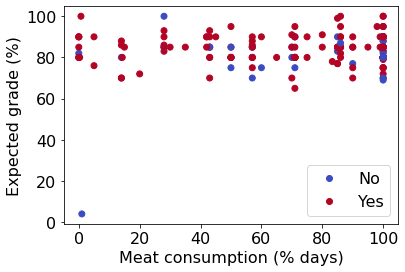

In [74]:
scatter = plt.scatter(df["meat"], df["grade"], c=df["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

In [72]:
scatter.legend_elements()[0]

Can you find yourself on this plot?!

In [7]:
df["cilantro"].value_counts()

Yes    144
No      56
Name: cilantro, dtype: int64

In [11]:
X = df[["meat", "grade"]]
X.head()

,meat,grade
0,42.0,90
1,85.0,83
2,28.0,83
3,100.0,80
4,100.0,75


In [9]:
y = df["cilantro"]
y.head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: cilantro, dtype: object

In [12]:
dc = DummyClassifier(strategy="prior")

In [13]:
dc.fit(X, y)
dc.score(X, y)

0.72

In [14]:
y.value_counts()/len(y)

Yes    0.72
No     0.28
Name: cilantro, dtype: float64

## Decision trees (20 min)

- Our first approach to supervised learning: **decision trees**.
- Basic idea: ask a bunch of yes/no questions until you end up at a prediction.
- E.g. for our cilantro dataset,
  - If you eat meat <5% of the time, predict "Yes"
  - Otherwise, if you eat meat >95% of the time, predict "No"
  - Otherwise, if you expect to fail the course, predict "No"
  - Otherwise, predict "Yes"

- This "series of questions" approach can be drawn as a tree:

```
            Eats meat <5% of the time
            /          \
           / True       \  False
          /              \
         Yes           Eats meat >95% of the time
                        /      \
                  True /        \ False
                      /          \ 
                    No         Expects to fail the course (<50%)
                                 /           \
                                / True        \ False
                               /               \
                              No              Yes
```

- The decision tree algorithm automatically learns a tree like this, based on the data set!
  - We won't go through **how** it does this - that's CPSC 340.
  - But it's worth noting that it support two types of inputs:

1. Categorical (e.g., Yes/No or more options)
2. Numeric (a number)

In the numeric case, the decision tree algorithm also picks the _threshold_ (e.g. 5%, 50%, etc.)

In our case here, both features are numeric.

Let's apply a decision tree to our cilantro dataset.

In [16]:
tree1 = DecisionTreeClassifier(max_depth=1)

- Here, we create a `DecisionTreeClassifier` object from scikit-learn.
- We pass in parameters - these are called **hyperparameters** - in this case `max_depth=1` which means the tree can only have depth 1.
- Next we fit to the data using `.fit()`.
- The semicolon is just cosmetic, otherwise some junk gets printed out.

In [17]:
tree1.fit(X, y);

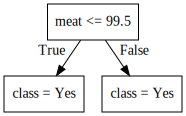

In [18]:
display_tree(df.columns[:-1], tree1)

- This is a totally useless decision tree that predicts "Yes" for any feature.
- This happens sometimes. Let's roll with it for the moment.

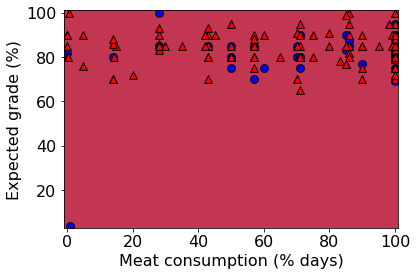

In [19]:
plot_classifier(X, y, tree1, ticks=True, vmin=0, vmax=1); # note to self: need to set vmin/vmax to to an issue with plot_classifier that always draws blue if all predictions are the same
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

- The background colour shows our prediction.
- We predict red (likes cilantro) for any features.
- We can get an accuracy score using `.score()` from sklearn

In [20]:
tree1.score(X, y)

0.72

- This is doing the same thing as `DummyClassifier` so we get the same score.
- We can verify this using `.predict()`

In [21]:
tree1.predict([[50, 50]])

array(['Yes'], dtype=object)

In [22]:
tree1.predict([[99,99]])

array(['Yes'], dtype=object)

In [23]:
tree1.predict(X)

array(['Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes',

etc.

- Let's make the tree deeper by increasing `max_depth`.

In [24]:
tree2 = DecisionTreeClassifier(max_depth=2)
tree2.fit(X, y);

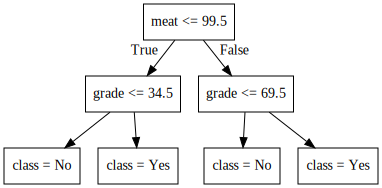

In [25]:
display_tree(df.columns[:-1], tree2)

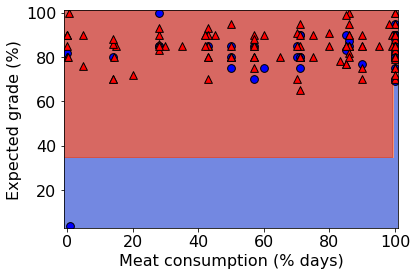

In [27]:
plot_classifier(X, y, tree2, ticks=True, show_data=True);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

- Let's take a moment to make sure we can correspond the tree diagram to this diagram - they are saying the same thing.

In [28]:
tree2.score(X, y)

0.73

- By the way, what does `.score()` do?
- It calls `predict` and then compares the predictions to the true labels.

In [62]:
(tree2.predict(X) == y).sum()/len(y)

0.73

Or, equivalently,

In [60]:
(tree2.predict(X) == y).mean()

0.73

In [63]:
y

0      Yes
1       No
2      Yes
3       No
4       No
      ... 
195    Yes
196    Yes
197    Yes
198    Yes
199    Yes
Name: cilantro, Length: 200, dtype: object

Moving on to `max_depth=None`, which lets it grow the tree as much as it wants.

In [29]:
tree = DecisionTreeClassifier(max_depth=None)
tree.fit(X, y);

In [44]:
tree.predict([[90, 90]])

array(['Yes'], dtype=object)

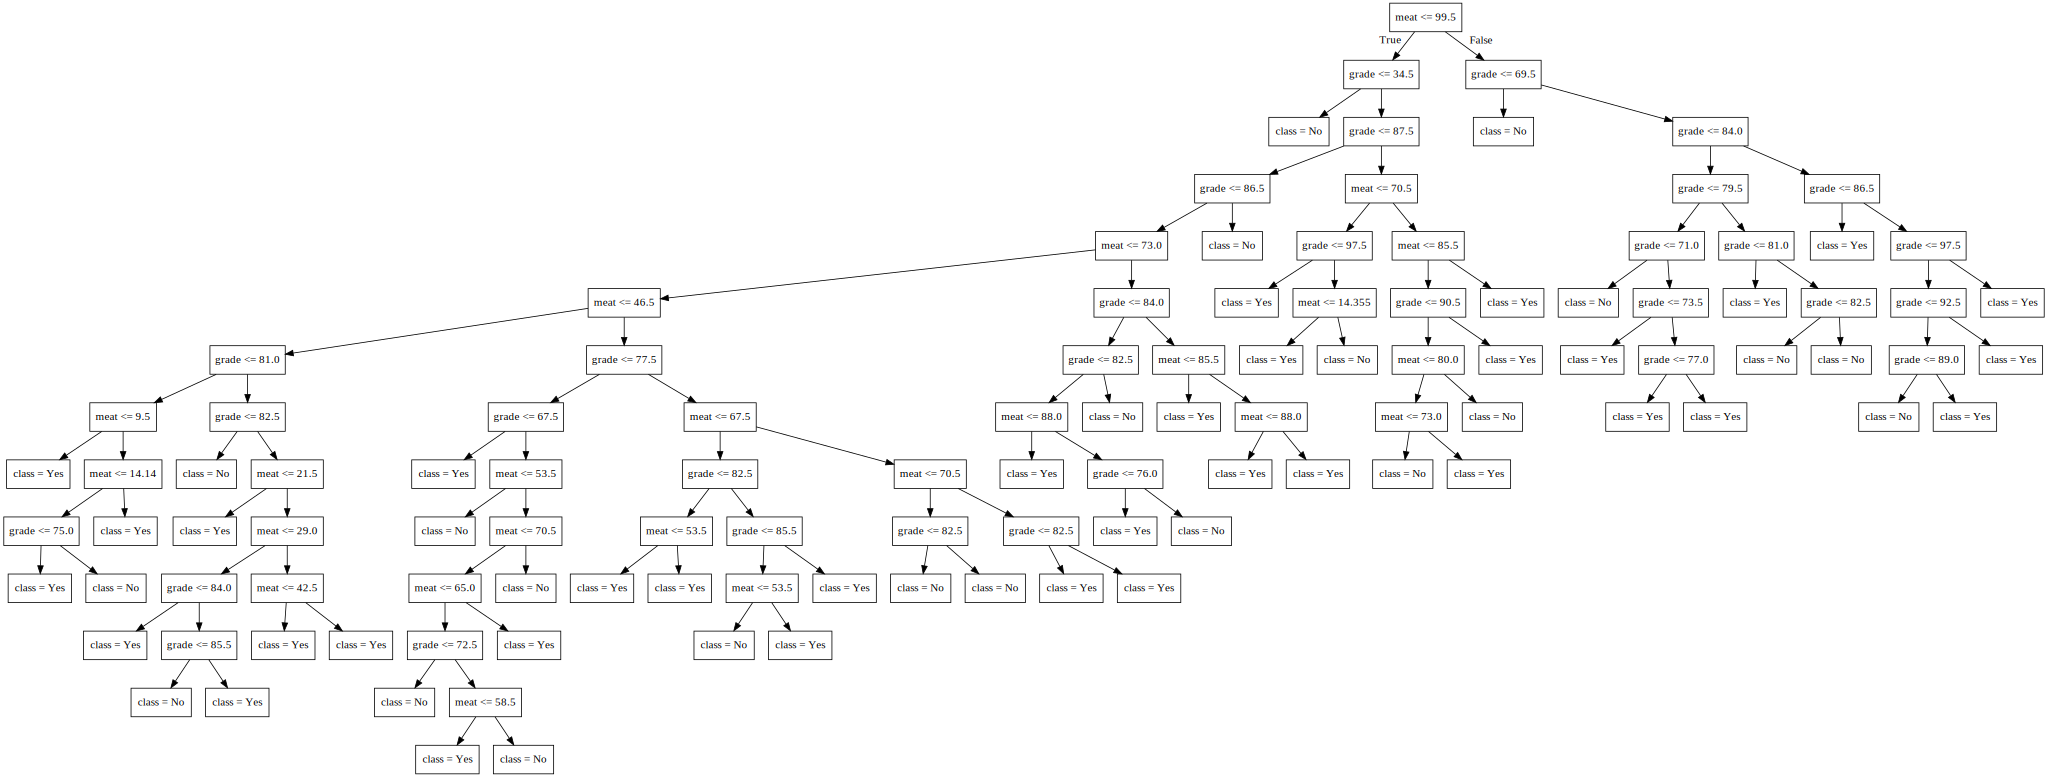

In [30]:
display_tree(df.columns[:-1], tree)

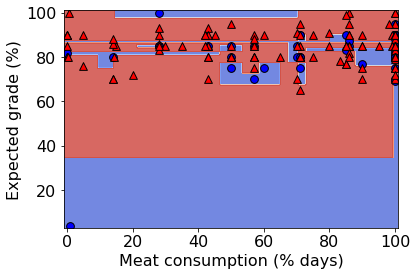

In [31]:
plot_classifier(X, y, tree, ticks=True);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

In [32]:
tree.score(X, y)

0.805

The reason it's not getting 100% accuracy: instances of duplicated features

In [33]:
# it's OK if you don't understand this line
df.loc[df.duplicated(subset=df.columns[:-1], keep=False)].sort_values(by=df.columns.values.tolist()).head(20)

,meat,grade,cilantro
19,0.0,80,Yes
62,0.0,80,Yes
100,0.0,80,Yes
143,0.0,90,Yes
170,0.0,90,Yes
198,0.0,90,Yes
69,14.0,70,Yes
130,14.0,70,Yes
31,28.0,85,No
162,28.0,85,No


If we remove the "duplicates" (cases where X is the same, not y) then we can get 100% accuracy:

In [35]:
# it's OK if you don't understand this line
df_nodup = df.sort_values(by="cilantro").drop_duplicates(subset=df.columns[:-1]).reset_index(drop=True)

In [36]:
df_nodup.shape

(95, 3)

In [37]:
X_nodup = df_nodup.iloc[:,:2]
y_nodup = df_nodup.iloc[:,-1]

In [38]:
tree_nodup = DecisionTreeClassifier() # default is max_depth=None

In [39]:
tree_nodup.fit(X_nodup, y_nodup);

In [40]:
tree_nodup.score(X_nodup, y_nodup)

1.0

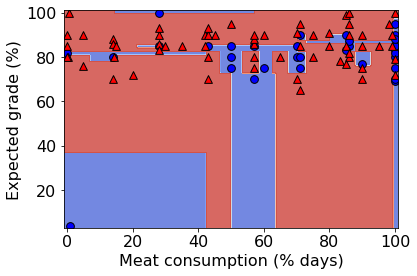

In [41]:
plot_classifier(X_nodup, y_nodup, tree_nodup, ticks=True);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");

Note: one would not actually remove the duplicates in a real scenario. This is just for illustration purposes.

## Break (5 mins)

## True/False questions (15 min)

For each of the following, answer with `fit` or `predict`:

1. At least for decision trees, this is where most of the hard work is done.
2. Only takes `X` as an argument.
3. In scikit-learn, we can ignore its output.
4. Is called first (before the other one).

<br><br><br><br><br><br>

##  ML model parameters and hyperparameters (5 mins)

- When you call `fit`, a bunch of values get set, like the split variables and split thresholds. 
- These are called **parameters**.
- But even before calling `fit` on a specific data set, we can set some "knobs" that control the learning, e.g. `max_depth`.
- These are called **hyperparameters**.

In scikit-learn, hyperparameters are set in the constructor:

In [ ]:
tree = DecisionTreeClassifier(max_depth=3) 
tree.fit(X, y);

Here, `max_depth` is a hyperparameter. There are many, many more! See [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).



To summarize:

- **parameters** are automatically learned by the algorithm during training (`fit`)
- **hyperparameters** are specified by the human, before `fit`, based on:
    - expert knowledge
    - heuristics, or 
    - systematic/automated optimization (more on that later on)

## Overfitting (15 mins)

Important question: how does accuracy change vs. max_depth?

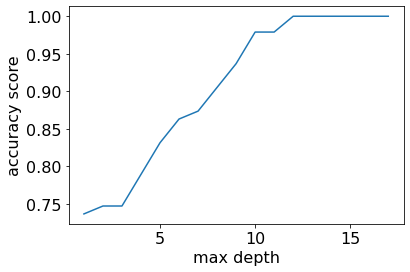

In [46]:
# it would be good to understand this code, but not that urgent
# I am using a list comprehension but you might find it easier to understand with a `for` loop - post on Piazza for more info
max_depths = np.arange(1, 18)
scores = [DecisionTreeClassifier(max_depth=max_depth).fit(X_nodup, y_nodup).score(X_nodup, y_nodup) for max_depth in max_depths]
plt.plot(max_depths, scores);
plt.xlabel("max depth");
plt.ylabel("accuracy score");

- Why not just use a very deep decision tree for every supervised learning problem and get super high accuracy?
- Well, the goal of supervised learning is to predict unseen/new data...
  - The above decision tree has 100% accuracy on the training data **where we already know the answer**.
  - It perfectly labels the data we used to make the tree...
  - But we want to know how our model performs on data not used in training.
  - We will split our original dataset into two parts, one for "training" and one for "testing".

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
df_train, df_test = train_test_split(df_nodup)

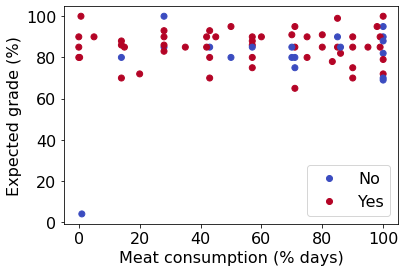

In [75]:
scatter = plt.scatter(df_train["meat"], df_train["grade"], c=df_train["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

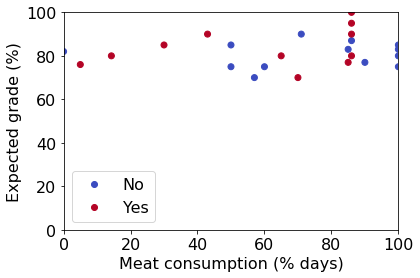

In [76]:
scatter = plt.scatter(df_test["meat"], df_test["grade"], c=df_test["cilantro"]=="Yes", cmap=plt.cm.coolwarm);
plt.xlabel("Meat consumption (% days)");
plt.ylabel("Expected grade (%)");
plt.xlim((0,100));
plt.ylim((0,100));
plt.legend(scatter.legend_elements()[0], ["No", "Yes"]);

## Summary

- Cilantro dataset: predict whether a CPSC 330 student likes cilantro (yes/no) from their meat consumption and expected grade (numeric features)
- Decision trees: a classifier that makes predictions by sequentially looking at features and checking whether they are above/below a threshold
- Decision trees learn axis-aligned decision boundaries (vertical and horizontal lines with 2 features)
- `fit(X,y)`: train classifier from training data
- `predict(X)`: make one or more predictions given a trained classifier
- `score(X,y)`: makes predictions with `predict()` and compares them to the true answers passed in as `y`
- Classifiers have hyperparameters, which are set before calling `fit`
  - Often set by humans, but not always (see later lecture)
- `max_depth` is a hyperparameter of `DecisionTreeClassifier` that controls the maximum depth of the learned tree  
- larger `max_depth` -> larger accuracy on training data
- `DecisionTreeClassifier` with `max_depth=None` not getting 100% training accuracy when two students have the same features but different target values